<a href="https://colab.research.google.com/github/lqdungx/TTNT/blob/main/CGAN_NMIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from tqdm import tqdm
import os

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Config
batch_size = 128
image_size = 28
num_classes = 10
nz = 100   # chiều noise vector
sample_dir = "./samples"
os.makedirs(sample_dir, exist_ok=True)


Device: cuda


In [12]:
# Transform: scale ảnh về [-1,1]
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load MNIST
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Số batch mỗi epoch:", len(dataloader))


Số batch mỗi epoch: 469


In [13]:
def one_hot(labels, num_classes):
    return F.one_hot(labels, num_classes).float()


In [14]:
class Generator(nn.Module):
    def __init__(self, nz, num_classes, ngf=64):
        super(Generator, self).__init__()
        self.nz = nz
        self.num_classes = num_classes
        self.fc = nn.Linear(nz + num_classes, ngf*7*7)

        self.net = nn.Sequential(
            nn.BatchNorm2d(ngf),
            nn.ConvTranspose2d(ngf, ngf//2, 4, 2, 1),
            nn.BatchNorm2d(ngf//2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf//2, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, labels_onehot):
        x = torch.cat([z, labels_onehot], dim=1)  # (B, nz+num_classes)
        x = self.fc(x)
        x = x.view(-1, 64, 7, 7)
        x = self.net(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, num_classes, ndf=64):
        super(Discriminator, self).__init__()
        self.num_classes = num_classes
        self.net = nn.Sequential(
            nn.Conv2d(1 + num_classes, ndf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(ndf*2*7*7, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels_onehot):
        b = img.size(0)
        lab = labels_onehot.view(b, self.num_classes, 1, 1).expand(-1, self.num_classes, image_size, image_size)
        x = torch.cat([img, lab], dim=1)  # concat theo channel
        return self.net(x)


In [15]:
netG = Generator(nz, num_classes).to(device)
netD = Discriminator(num_classes).to(device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

real_label = 1.
fake_label = 0.

# fixed noise và nhãn để quan sát sự tiến triển
fixed_noise = torch.randn(64, nz, device=device)
fixed_labels = torch.arange(0, num_classes).repeat(6)[:64].to(device)
fixed_labels_oh = one_hot(fixed_labels, num_classes).to(device)

In [21]:
import torch.nn.functional as F
from tqdm import tqdm

# Tham số huấn luyện
num_epochs = 30
real_label = 1.0
fake_label = 0.0
iters = 0

# Noise + nhãn cố định để theo dõi tiến trình sinh ảnh
fixed_noise = torch.randn(64, nz, device=device)
fixed_labels = torch.arange(10).repeat(7)[:64].to(device)   # 64 nhãn
fixed_labels_oh = F.one_hot(fixed_labels, num_classes=num_classes).float()

print("Start Training...")

for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for imgs, labels in pbar:
        imgs = imgs.to(device)              # (B,1,28,28)
        b_size = imgs.size(0)

        # One-hot cho nhãn thật
        labels_oh = F.one_hot(labels, num_classes=num_classes).float().to(device)

        ### Train Discriminator ###
        netD.zero_grad()
        # ảnh thật
        label_real = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        out_real = netD(imgs, labels_oh).view(-1)
        errD_real = criterion(out_real, label_real)
        errD_real.backward()

        # ảnh giả
        noise = torch.randn(b_size, nz, device=device)
        random_labels = torch.randint(0, num_classes, (b_size,), device=device)
        random_labels_oh = F.one_hot(random_labels, num_classes=num_classes).float()
        fake_imgs = netG(noise, random_labels_oh)
        label_fake = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
        out_fake = netD(fake_imgs.detach(), random_labels_oh).view(-1)
        errD_fake = criterion(out_fake, label_fake)
        errD_fake.backward()

        optimizerD.step()

        ### Train Generator ###
        netG.zero_grad()
        label_gen = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        out_fake2 = netD(fake_imgs, random_labels_oh).view(-1)
        errG = criterion(out_fake2, label_gen)
        errG.backward()
        optimizerG.step()

        ### In log
        pbar.set_postfix({
            "Loss_D": (errD_real+errD_fake).item(),
            "Loss_G": errG.item()
        })

        ### Sinh ảnh mẫu định kỳ
        if iters % 500 == 0:
            with torch.no_grad():
                fake_fixed = netG(fixed_noise, fixed_labels_oh).detach()
            utils.save_image((fake_fixed+1)/2, f"{sample_dir}/iter_{iters}.png", nrow=8)
        iters += 1


Start Training...


Epoch 30/30: 100%|██████████| 469/469 [00:21<00:00, 22.06it/s, Loss_D=1.07, Loss_G=4.45]


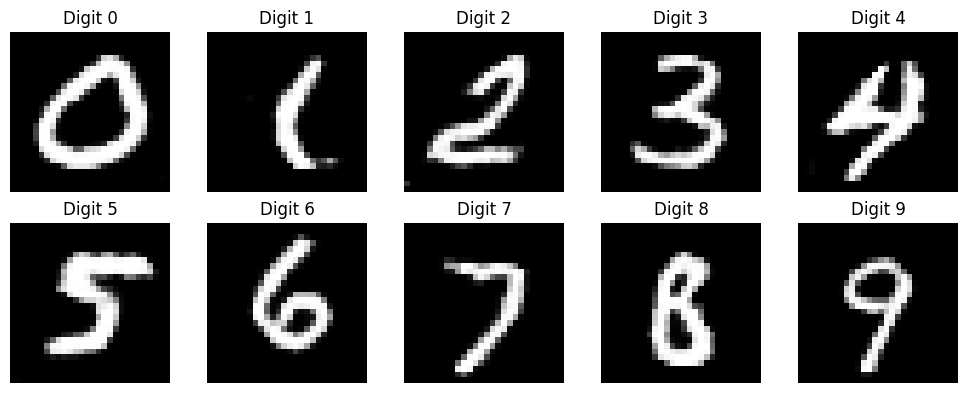

In [22]:
import matplotlib.pyplot as plt

def show_generated_digits(generator, nz, num_classes, device):
    generator.eval()
    fig, axes = plt.subplots(2, 5, figsize=(10,4))
    for i in range(num_classes):
        z = torch.randn(1, nz, device=device)
        label = torch.tensor([i], device=device)
        label_oh = F.one_hot(label, num_classes).float()
        with torch.no_grad():
            fake_img = generator(z, label_oh).cpu()
        img = (fake_img.squeeze().numpy() + 1) / 2.0   # scale về [0,1]
        ax = axes[i//5, i%5]
        ax.imshow(img, cmap="gray")
        ax.set_title(f"Digit {i}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Gọi thử
show_generated_digits(netG, nz, num_classes, device)
